#### Submission Akhir: Image Classification Model Deployment
# Traffic Sign Classification


By: Diah Ayu Setyaningsih


## Download Dataset

- Single-image, multi-class classification problem
- More than 40 classes
- More than 50,000 images in total (I only use the training images)
- Physical traffic sign instances are unique within the dataset
(i.e., each real-world traffic sign only occurs once)
- Image sizes vary between 15x15 to 250x250 pixels

source: http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset

In [1]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

--2020-08-29 02:35:44--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  19.3MB/s    in 15s     

2020-08-29 02:36:00 (17.4 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



In [2]:
!unzip /content/GTSRB_Final_Training_Images.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: GTSRB/Final_Training/Images/00035/00000_00020.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00021.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00022.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00023.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00024.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00025.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00026.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00027.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00028.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00029.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00000.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00001.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00002.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00003.ppm  
  inflating: GTSRB/Final_Traini

## Import Module

In [3]:
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import files
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau, Callback

## Data Exploration

### Display one image for each label

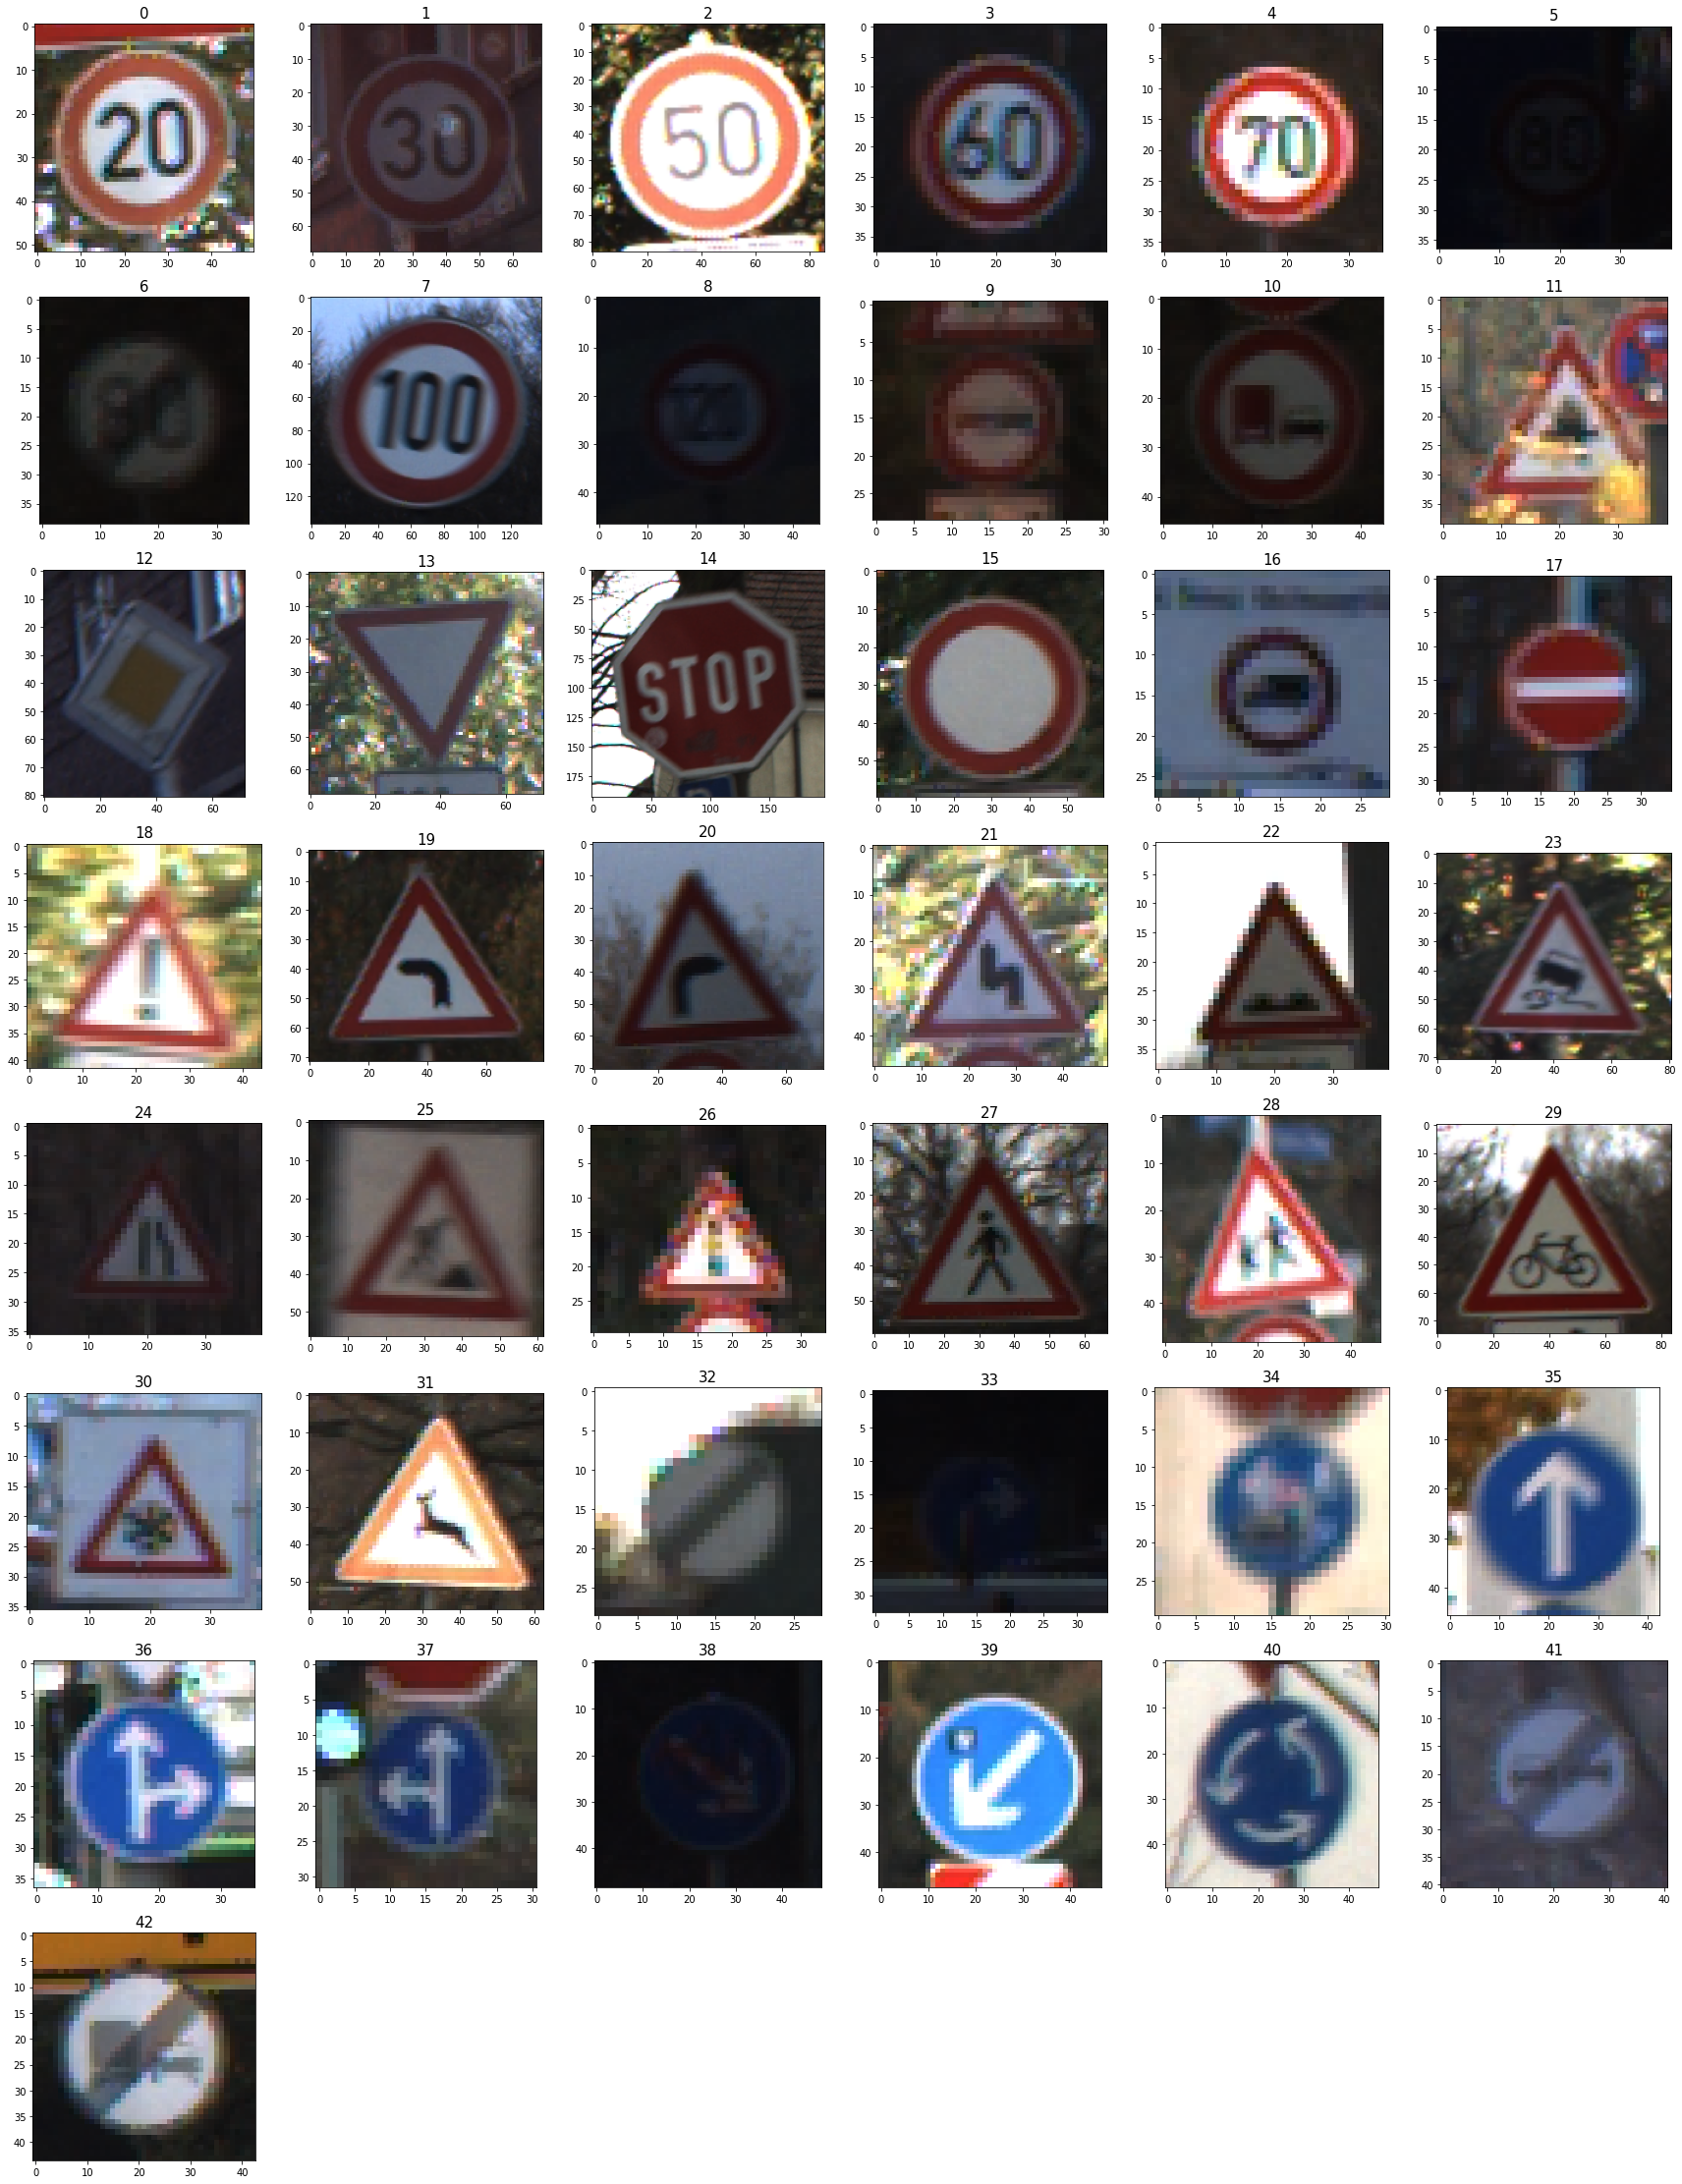

In [4]:
base_dir = '/content/GTSRB/Final_Training/Images/'

fig = plt.figure(figsize=(30, 40))
columns = 6
rows = 8

freq = {}
for i in range(0, 43):
    if i <10:
        sub_dir = base_dir + '0000' + str(i)
    else:
        sub_dir = base_dir + '000' + str(i)
    path_list = os.listdir(sub_dir)
    freq[i] = len(path_list)
    sample_path = random.sample(path_list,1)
    path=os.path.join(sub_dir,sample_path[0])
    img = image.load_img(path)
    axs=fig.add_subplot(rows, columns, i+1)
    axs.set_title(str(i), fontsize=15)
    plt.imshow(img)
plt.tight_layout
plt.show()

### Label Distribution

We can see that the dataset is imbalance. I have tried to handle it using class weight but the result is not better than without class weight. So, in this project, I will not use class weight and since the data quite a lot, I will let deep learning to cope with this.

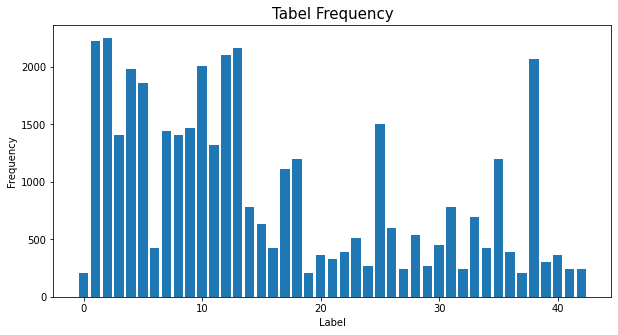

In [5]:
fig = plt.figure(figsize=(10, 5))
plt.bar(freq.keys(), freq.values())
plt.title('Tabel Frequency', fontsize=15)
plt.ylabel('Frequency')
plt.xlabel('Label')
plt.show()

## Data Split and Data Augmentation

In [6]:
datagen = ImageDataGenerator(rotation_range=45,
                             zoom_range=[0.75,1.2],
                             rescale=1./255.,
                             validation_split=0.2)

train_generator = datagen.flow_from_directory(
    directory=base_dir,
    subset="training",
    batch_size=64,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(30,30))

valid_generator = datagen.flow_from_directory(
    directory=base_dir,
    subset="validation",
    batch_size=64,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(30,30))

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


### Show several train image

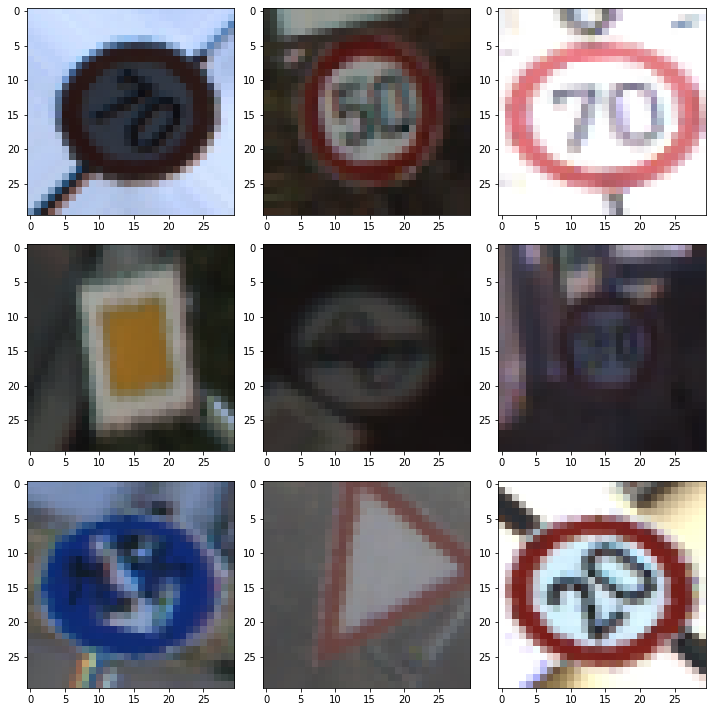

In [7]:
fig=plt.figure(figsize=(10, 10))
columns = 3
rows = 3

x, y = train_generator.next()

for i in range(0, columns*rows):
    axs=fig.add_subplot(rows, columns, i+1)
    img = x[i]
    plt.imshow(img)
plt.tight_layout()
plt.show()

## Create Model

In [8]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(30,30,3)))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu'))

model.add(Dense(43, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0

## Callbacks

In [9]:
class TerminateOnBaseline(Callback):
    """ Callback that terminates training when accuracy and val_accuracy 
        reache a specified baseline.
    """
    def __init__(self, baseline=0.9):
        super(TerminateOnBaseline, self).__init__()
        self.baseline = baseline

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        if acc is not None:
            if (acc >= self.baseline) & (val_acc >= self.baseline):
                print('\nEpoch %d: Reached baseline, terminating training' % (epoch+1))
                self.model.stop_training = True

In [10]:
Stopping = TerminateOnBaseline(baseline=0.92)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.5,
                                   patience=2,
                                   verbose=2,
                                   mode='auto')

callback_list = [reduceLROnPlat, Stopping]

## Training Model

In [11]:
train_step_size = math.ceil(train_generator.n/train_generator.batch_size)
valid_step_size = math.ceil(valid_generator.n/valid_generator.batch_size)

history = model.fit(train_generator,
                    steps_per_epoch=train_step_size,
                    validation_data=valid_generator,
                    validation_steps=valid_step_size,
                    epochs=50,
                    shuffle=True,
                    callbacks=callback_list)


Epoch 1/50
491/491 [==============================] - 24s 48ms/step - loss: 2.6712 - accuracy: 0.2353 - val_loss: 1.9809 - val_accuracy: 0.3718
Epoch 2/50
491/491 [==============================] - 24s 49ms/step - loss: 1.5357 - accuracy: 0.4927 - val_loss: 1.3351 - val_accuracy: 0.5582
Epoch 3/50
491/491 [==============================] - 24s 49ms/step - loss: 0.9874 - accuracy: 0.6679 - val_loss: 0.9013 - val_accuracy: 0.7053
Epoch 4/50
491/491 [==============================] - 24s 49ms/step - loss: 0.6699 - accuracy: 0.7742 - val_loss: 0.7614 - val_accuracy: 0.7639
Epoch 5/50
491/491 [==============================] - 23s 47ms/step - loss: 0.4946 - accuracy: 0.8361 - val_loss: 0.6101 - val_accuracy: 0.8207
Epoch 6/50
491/491 [==============================] - 23s 47ms/step - loss: 0.4018 - accuracy: 0.8704 - val_loss: 0.5389 - val_accuracy: 0.8338
Epoch 7/50
491/491 [==============================] - 22s 46ms/step - loss: 0.3305 - accuracy: 0.8940 - val_loss: 0.4556 - val_accuracy:

## Plot Training History

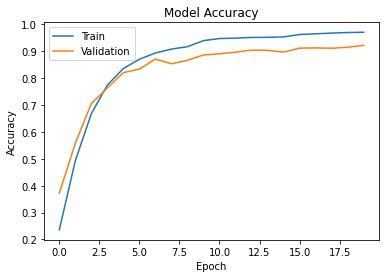

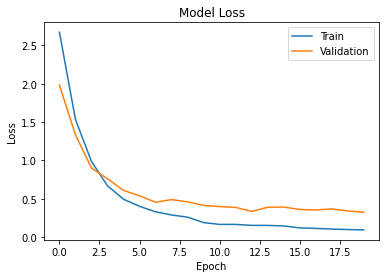

In [12]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

## Predict Image

Saving image 6.jpg to image 6.jpg
Saving image 1.png to image 1.png
Saving image 2.png to image 2.png
Saving images 3.jpg to images 3.jpg
Saving images 4.jpg to images 4.jpg
Saving images 5.png to images 5.png
Saving image 7.jpg to image 7.jpg
Saving image 8.png to image 8.png
Saving images 9.jpg to images 9.jpg


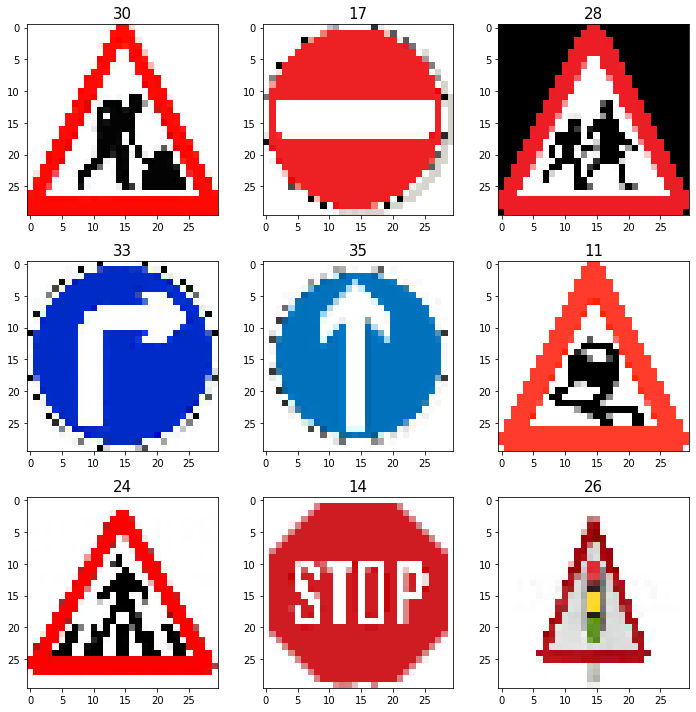

In [13]:
# manual upload
uploaded = files.upload()

fig=plt.figure(figsize=(10, 10))
columns = 3
rows = 3

for i, fn in enumerate(uploaded.keys()):
    # load images
    path = fn
    img = image.load_img(path, target_size=(30,30))
    
    #preprocess
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # predicting
    images = np.vstack([x])
    predicted = model.predict(images, batch_size=8)
    label=np.argmax(predicted,axis=1)
    axs=fig.add_subplot(rows, columns, i+1)
    axs.set_title(str(label[0]), fontsize=15)
    plt.imshow(img)

plt.tight_layout()
plt.show()

## Convert Tensorflow Model to TFLite

In [15]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpb77rdxq7/assets


INFO:tensorflow:Assets written to: /tmp/tmpb77rdxq7/assets
